Generating data...
Training model...
Epoch 0, Loss: 189758.0938
Epoch 10, Loss: 152021.7656
Epoch 20, Loss: 138967.0312
Epoch 30, Loss: 124479.0469
Epoch 40, Loss: 107414.6094
Epoch 50, Loss: 89639.5703
Epoch 60, Loss: 72507.9219
Epoch 70, Loss: 58279.0078
Epoch 80, Loss: 46772.6680
Epoch 90, Loss: 37575.0039
Epoch 100, Loss: 30064.7324
Epoch 110, Loss: 23843.9629
Epoch 120, Loss: 18598.1816
Epoch 130, Loss: 14106.0791
Epoch 140, Loss: 10211.8867
Epoch 150, Loss: 6804.2246
Epoch 160, Loss: 3799.7800
Epoch 170, Loss: 1135.2001
Epoch 180, Loss: -1239.4204
Epoch 190, Loss: -3236.2234
Epoch 200, Loss: -5213.4087
Epoch 210, Loss: -6923.7998
Epoch 220, Loss: -8440.0039
Epoch 230, Loss: -9819.1768
Epoch 240, Loss: -11066.4775
Epoch 250, Loss: -12206.5049
Epoch 260, Loss: -13244.2334
Epoch 270, Loss: -14190.4668
Epoch 280, Loss: -15052.3281
Epoch 290, Loss: -15545.1797
Epoch 300, Loss: -16503.9824
Epoch 310, Loss: -17203.9219
Epoch 320, Loss: -17795.9844
Epoch 330, Loss: -18353.1250
Epoch 340,

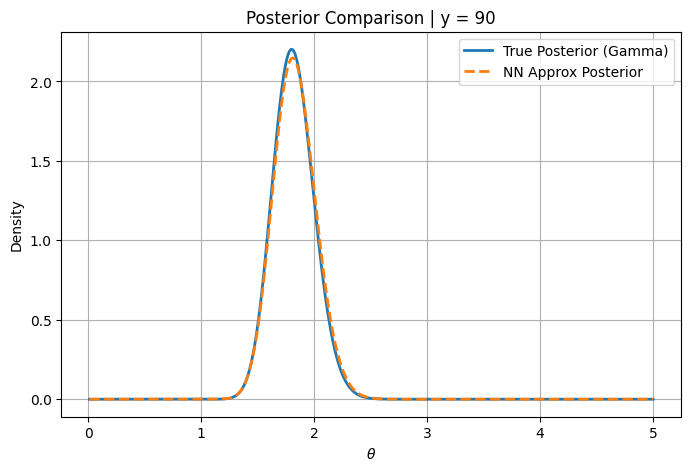

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.stats import gamma, poisson
import matplotlib.pyplot as plt
from collections import defaultdict
import random

# ============================== #
#      1. Global Configuration
# ============================== #
SEED = 123
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ============================== #
#      2. Define Model
# ============================== #
class GammaPosteriorNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.alpha_net = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 4),
            nn.ReLU(),
            nn.Linear(4, 1),
            nn.Softplus()  # ensure α > 0
        )
        self.beta_net = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Softplus()  # ensure β > 0
        )

    def forward(self, x):
        alpha = self.alpha_net(x)
        beta = self.beta_net(x)
        return alpha, beta

# ============================== #
#      3. Data Generation
# ============================== #
def simulate_gamma_poisson_data(M, n_trials, alpha, beta_param):
    """
    θ ~ Gamma(α, β)
    y ~ Poisson(n * θ)
    """
    theta_samples = np.random.gamma(shape=alpha, scale=1 / beta_param, size=M)
    y_samples = np.random.poisson(lam=n_trials * theta_samples)
    return theta_samples.reshape(-1, 1), y_samples.reshape(-1, 1)

# ============================== #
#      4. Group theta by y
# ============================== #
def group_theta_by_y(theta_samples, y_samples):
    data = np.column_stack([theta_samples.squeeze(), y_samples.squeeze()])
    theta_dict = defaultdict(list)
    for y in np.unique(y_samples):
        theta_dict[y] = data[data[:, 1] == y, 0]
    return theta_dict

# ============================== #
#      5. Train Neural Network
# ============================== #
def train_model(model, theta_dict, y_max, epochs=1000, lr=1e-2):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        total_log_likelihood = 0.0
        model.train()
        for y_val, theta_vals in theta_dict.items():
            if len(theta_vals) < 20:
                continue
            x = torch.tensor([[y_val / y_max]], dtype=torch.float32)
            theta = torch.tensor(theta_vals, dtype=torch.float32).view(-1, 1)
            theta = torch.clamp(theta, min=1e-6)

            alpha_pred, beta_pred = model(x)

            log_probs = (
                (alpha_pred - 1) * torch.log(theta) -
                beta_pred * theta -
                torch.lgamma(alpha_pred) +
                alpha_pred * torch.log(beta_pred)
            )
            total_log_likelihood += log_probs.sum()

        loss = -total_log_likelihood
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# ============================== #
#      6. Visualize Posterior
# ============================== #
def plot_posterior_comparison(model, y_obs, n_trials, prior_alpha, prior_beta, y_max):
    x = torch.tensor([[y_obs / y_max]], dtype=torch.float32)
    with torch.no_grad():
        alpha_pred, beta_pred = model(x)
    alpha_val = alpha_pred.item()
    beta_val = beta_pred.item()

    # True posterior
    alpha_post = prior_alpha + y_obs
    beta_post = prior_beta + n_trials
    true_posterior = gamma(a=alpha_post, scale=1 / beta_post)

    theta_range = np.linspace(0.01, 5.0, 300)
    true_pdf = true_posterior.pdf(theta_range)
    nn_pdf = gamma.pdf(theta_range, a=alpha_val, scale=1 / beta_val)

    plt.figure(figsize=(8, 5))
    plt.plot(theta_range, true_pdf, label="True Posterior (Gamma)", lw=2)
    plt.plot(theta_range, nn_pdf, '--', label="NN Approx Posterior", lw=2)
    plt.title(f"Posterior Comparison | y = {y_obs}")
    plt.xlabel(r"$\theta$")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()

# ============================== #
#      7. Main Program
# ============================== #
if __name__ == "__main__":
    # Prior parameters and simulation config
    prior_alpha = 10
    prior_beta = 5
    M = 100000
    n_trials = 50

    print("Generating data...")
    theta_samples, y_samples = simulate_gamma_poisson_data(M, n_trials, prior_alpha, prior_beta)
    theta_dict = group_theta_by_y(theta_samples, y_samples)
    y_max = y_samples.max()

    print("Training model...")
    model = GammaPosteriorNN()
    train_model(model, theta_dict, y_max, epochs=1000, lr=1e-2)

    # Visualization for specific y_obs
    y_obs = 90
    plot_posterior_comparison(model, y_obs, n_trials, prior_alpha, prior_beta, y_max)


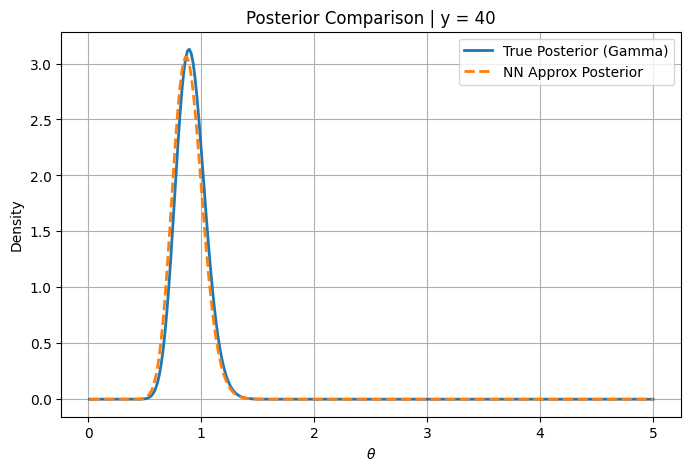

In [7]:
y_obs = 40
plot_posterior_comparison(model, y_obs, n_trials, prior_alpha, prior_beta, y_max)

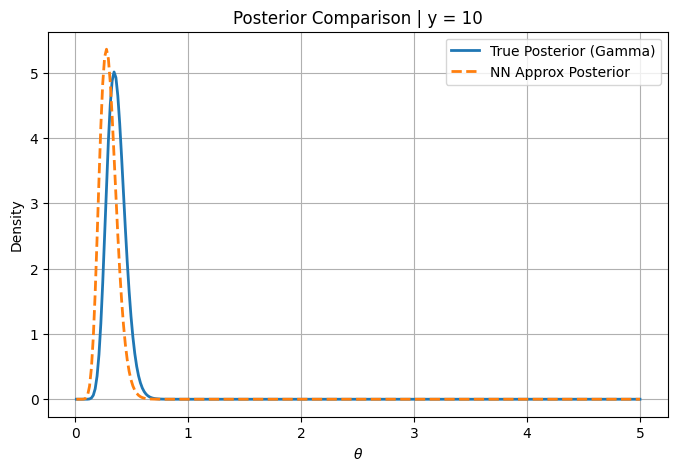

In [11]:
y_obs = 10
plot_posterior_comparison(model, y_obs, n_trials, prior_alpha, prior_beta, y_max)